In [1]:
import tensorflow as tf 
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [2]:
Batch_size = 32
Image_size = 256
Channels = 3
Epochs = 25

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (Image_size, Image_size),
    batch_size = Batch_size
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    # 1 image batch has 32 size which is defined above.

(32, 256, 256, 3)
[0 2 1 0 0 0 1 1 1 1 0 1 1 1 1 1 0 0 1 2 1 1 2 0 1 1 0 1 0 0 0 0]


2025-10-12 20:20:20.079011: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-10-12 20:20:20.244074: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


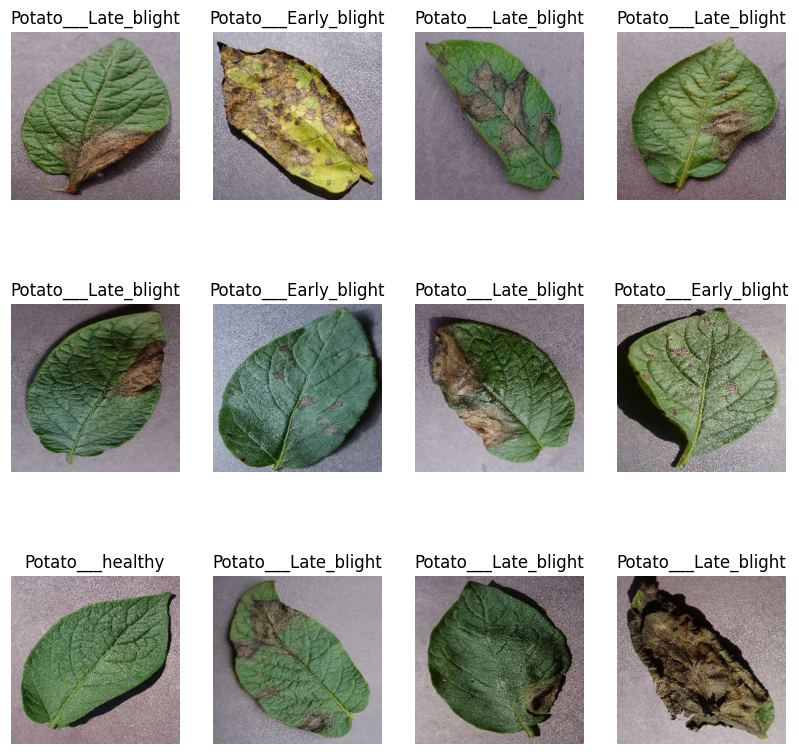

In [6]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
# 80% ==> training
# 20% ==> test
#     10% ==> validation
#     10% ==> test

In [8]:
len(dataset) # it give 68 because it divided into 32 batch size.

68

In [9]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [10]:
train_ds = dataset.take(54)
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [12]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split+val_split+test_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(dataset), len(train_ds), len(val_ds), len(test_ds)

(68, 54, 6, 8)

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy()/255)

[[[0.5294118  0.52156866 0.57254905]
  [0.57254905 0.5647059  0.6156863 ]
  [0.61960787 0.6117647  0.6627451 ]
  ...
  [0.7254902  0.7411765  0.78431374]
  [0.70980394 0.7254902  0.76862746]
  [0.6862745  0.7019608  0.74509805]]

 [[0.5803922  0.57254905 0.62352943]
  [0.5921569  0.58431375 0.63529414]
  [0.6117647  0.6039216  0.654902  ]
  ...
  [0.70980394 0.7254902  0.76862746]
  [0.6901961  0.7058824  0.7490196 ]
  [0.6627451  0.6784314  0.72156864]]

 [[0.6156863  0.60784316 0.65882355]
  [0.5921569  0.58431375 0.63529414]
  [0.58431375 0.5764706  0.627451  ]
  ...
  [0.7019608  0.7176471  0.7607843 ]
  [0.6784314  0.69411767 0.7372549 ]
  [0.6509804  0.6666667  0.70980394]]

 ...

 [[0.5058824  0.49411765 0.5372549 ]
  [0.43137255 0.41960785 0.4627451 ]
  [0.42745098 0.41568628 0.45882353]
  ...
  [0.5529412  0.54509807 0.5882353 ]
  [0.5529412  0.54509807 0.5882353 ]
  [0.5411765  0.53333336 0.5764706 ]]

 [[0.47843137 0.46666667 0.50980395]
  [0.42745098 0.41568628 0.45882353]


In [20]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(Image_size, Image_size),
    layers.Rescaling(1.0/255)
])

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [22]:
input_size = (Batch_size, Image_size, Image_size, Channels)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape = input_size),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_size)

/Users/rajivkumar/Desktop/Potato Project/Potato.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [25]:
history = model.fit(
    train_ds,
    batch_size = Batch_size,
    validation_data = val_ds,
    verbose = 1,
    epochs = Epochs
)

Epoch 1/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 697ms/step - accuracy: 0.4994 - loss: 0.9025 - val_accuracy: 0.5156 - val_loss: 0.8928
Epoch 2/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 660ms/step - accuracy: 0.7002 - loss: 0.6473 - val_accuracy: 0.7969 - val_loss: 0.4907
Epoch 3/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 692ms/step - accuracy: 0.8484 - loss: 0.3836 - val_accuracy: 0.6927 - val_loss: 0.7167
Epoch 4/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 711ms/step - accuracy: 0.8819 - loss: 0.2846 - val_accuracy: 0.9323 - val_loss: 0.1849
Epoch 5/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 722ms/step - accuracy: 0.9225 - loss: 0.1917 - val_accuracy: 0.7135 - val_loss: 0.7613
Epoch 6/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 733ms/step - accuracy: 0.9387 - loss: 0.1470 - val_accuracy: 0.9427 - val_loss: 0.1348
Epoch 7/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 741ms/step - accuracy: 0.9392 - loss: 0.1414 - val_accuracy: 0.8385 - val_loss: 0.5776
Epoch 8/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 744ms/step - accuracy: 0.9329 - loss: 0.1720 - val_accu

In [28]:
scores = model.evaluate(test_ds)
scores

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.9375 - loss: 0.2997


[0.2997087240219116, 0.9375]

In [29]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 54}

In [30]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

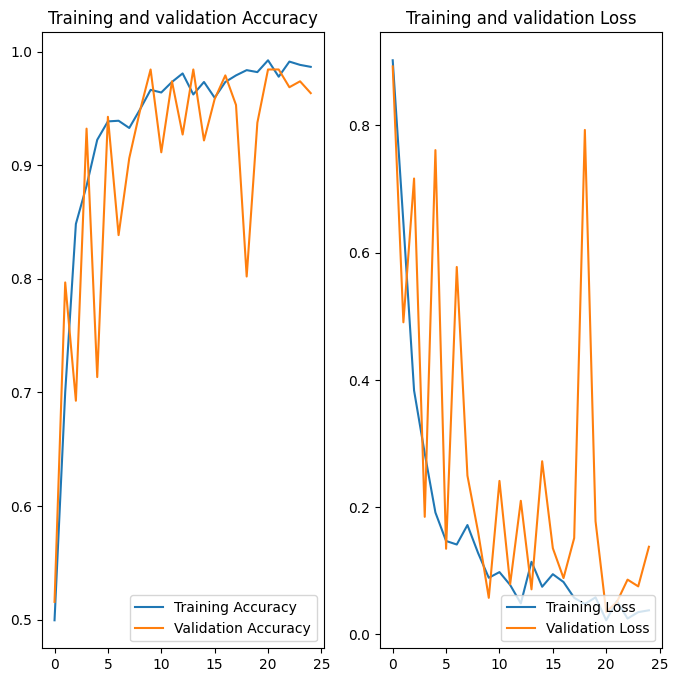

In [32]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(Epochs), acc, label = 'Training Accuracy')
plt.plot(range(Epochs), val_acc, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(Epochs), loss, label = 'Training Loss')
plt.plot(range(Epochs), val_loss, label = 'Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and validation Loss')

plt.show()

First image to predict
Actual Label:- Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
Predicted Label:- Potato___Late_blight


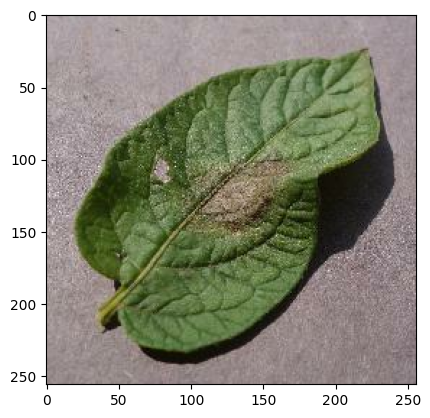

In [44]:
import numpy as np 
for image_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual Label:-", class_names[labels_batch[0].numpy()])

    batch_prediction = model.predict(image_batch)
    print("Predicted Label:-", class_names[np.argmax(batch_prediction[0])])

In [47]:
def predict(model, img):
    img_array = tf.keras.utils.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)

    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


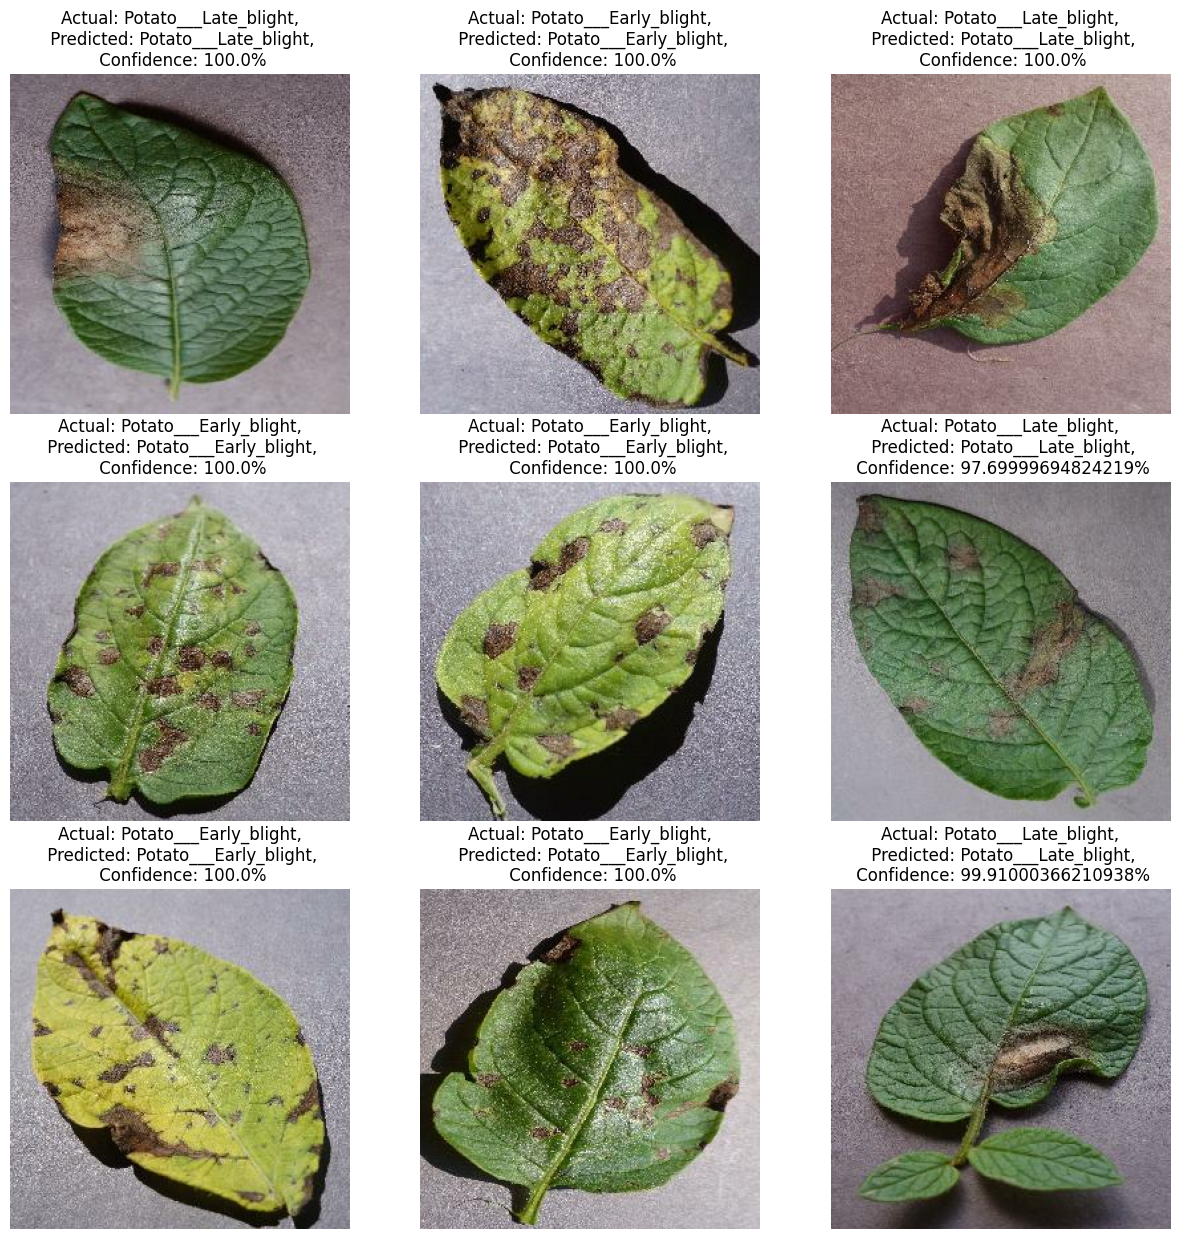

In [54]:
plt.figure(figsize=(15,15))
for images , labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class, confidence = predict(model, images.numpy())

        actual_class = class_names[labels[i]]
        plt.title(f'Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}%')
        plt.axis('off')

plt.show()

In [ ]:
model_version = 1
# Save model in native Keras format for reloading or retraining later
model.save(f"./Models/{model_version}.keras")

In [ ]:
# Export model in TensorFlow SavedModel format for deployment (e.g., FastAPI or TF Serving)
model.export(f"./Models/{model_version}_export")

INFO:tensorflow:Assets written to: ./Models/1_export/assets


INFO:tensorflow:Assets written to: ./Models/1_export/assets


Saved artifact at './Models/1_export'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  5394518560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5394518912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5394912656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5394910896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5394915296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5394914944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5394918288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5394915120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5394919872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5394917584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5394921456: TensorSpec(shape=(), dtype=tf.resource, name=None)
